In [61]:
#mv_model_rotation_error.sql
from enum import Enum
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import pandas as pd
import seaborn as sns
from funclib.iolib import folder_open
from dblib import mssql
from scipy import stats
from sklearn.metrics import mean_squared_error
from plotlib.mplfuncs import FigWidthsInch as Size

W = Size.two_col.value
H = W*0.667

sns.set()
sns.set(font="Times New Roman", font_scale=1.2, rc={"lines.linewidth": 1, "figure.figsize":(W,H)})
sns.set_style('ticks') #rc={'axes.grid':True}

In [58]:
sql="SELECT adjid ,'Model corrected' AS Correction ,rotation AS Angle ,bias_percent AS '% MBE' FROM adjust_all UNION SELECT adjid ,'Corrected' AS Correction ,rotation AS Angle ,all_corr_rot_adj2_mm_error_perc AS '% MBE' FROM adjust_all UNION SELECT adjid ,'Lens only' AS Correction ,rotation AS Angle ,mv_lens_correction_mm_error_perc AS '% MBE' FROM adjust_all "

with mssql.Conn('imagedb', '(local)') as cnn:
    dfadj = pd.read_sql(sql, cnn)
list(dfadj)

['adjid', 'Correction', 'Angle', '% MBE']

In [59]:
sql = "select count(*) as 'n' ,rotation as Angle, 'style' as style from adjust_all group by rotation"
with mssql.Conn('imagedb', '(local)') as cnn:
    dfN = pd.read_sql(sql, cnn)
list(dfN)

['n', 'Angle', 'style']

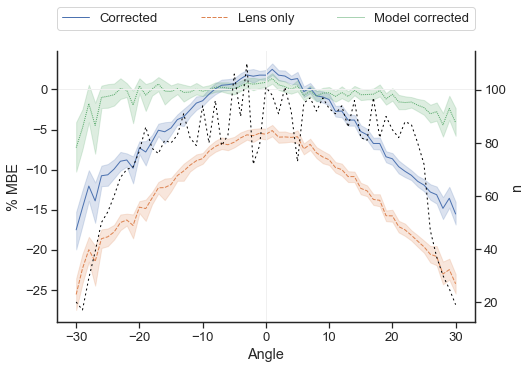

In [62]:
#mv_model_rotation_error.sql
#score > 0.5
g = sns.lineplot(x='Angle', y='% MBE', hue='Correction', style='Correction', data=dfadj, legend=None)
g.legend(g.lines, ('Corrected', 'Lens only', 'Model corrected'), bbox_to_anchor=(0,1.02,1,0.2), loc="center left", mode="expand", borderaxespad=0, ncol=3, title='')
ax_score = g.twinx()
sns.lineplot(x='Angle', y='n', data=dfN, ax=ax_score, hue='style', style='style', palette=['#000000'], linewidth=1, dashes=[(2,3)])

g.axvline(x=0, aa=False, color='#F0F0F0', linewidth=0.5)
g.axhline(y=0, aa=False, color='#F0F0F0', linewidth=0.5 )
ax_score.legend_.remove()
sns.despine(top=True, right=False)
#plt.tight_layout()



plt.savefig('C:/Users/Graham Monkman/OneDrive/Documents/PHD/My Papers/Fiducial_machine_vision_estimates/images/sklearn_forest_outliers/mv_graph_model.svg', bbox_inches='tight', dpi=500)
plt.savefig('C:/Users/Graham Monkman/OneDrive/Documents/PHD/My Papers/Fiducial_machine_vision_estimates/images/sklearn_forest_outliers/mv_graph_model.jpg', bbox_inches='tight')
folder_open('C:/Users/Graham Monkman/OneDrive/Documents/PHD/My Papers/Fiducial_machine_vision_estimates/images')

In [ ]:
#NOW some stats on model corrected

In [32]:
#load data
sql = "select rotation as Angle,bias_percent  from adjust_all where abs(rotation)<21"
with mssql.Conn('imagedb', '(local)') as cnn:
    df_t = pd.read_sql(sql, cnn)
list(df_t)


['Angle', 'bias_percent']

In [33]:
print(stats.ttest_1samp(df_t.bias_percent,0))

Ttest_1sampResult(statistic=-0.9119811640211566, pvalue=0.3618394442893953)


In [44]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

def mse(pred):
    def mse_(est):
        ndpred = np.zeros(est.shape[0]) + pred
        return mean_squared_error(ndpred, est)
    mse_.__name__ = 'mse_%s' % pred
    return mse_

def ci(data):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), stats.sem(a)
    h = se * stats.t.ppf((1 + 0.95) / 2., n-1)
    s = 'M=%0.1f 95%% CIs [%0.1f, %0.1f]' % (m, m-h, m+h)
    #return m, m-h, m+h
    return s


In [45]:
#dfadj ['adjid', 'Correction', 'Angle', '% MBE']
dfadj.groupby(['Correction']).agg({'% MBE':[np.median, percentile(25), percentile(75), mse(0), ci]})

% MAE                                          \
                    median percentile_25 percentile_75       mse_0   
Correction                                                           
Corrected        -3.429877     -8.068872      0.260054   55.458272   
Lens only       -10.701339    -15.373937     -6.929115  168.628534   
Model corrected  -0.388450     -2.482911      1.698465   17.494384   

                                                 
                                             ci  
Correction                                       
Corrected           M=-4.1 95% CIs [-4.3, -3.9]  
Lens only        M=-11.4 95% CIs [-11.6, -11.2]  
Model corrected     M=-0.5 95% CIs [-0.6, -0.3]

In [51]:
#same again but at 20 degrees
#load data
sql="select adjid ,'Model corrected' as Correction ,rotation as Angle ,bias_percent as '% MBE' from adjust_all where abs(rotation) < 21 union select adjid ,'Corrected' as Correction ,rotation as Angle ,all_corr_rot_adj2_mm_error_perc as '% MAE' from adjust_all where abs(rotation) < 21 union select adjid ,'Lens only' as Correction ,rotation as Angle ,mv_lens_correction_mm_error_perc as '% MAE' from adjust_all where abs(rotation) < 21 "

with mssql.Conn('imagedb', '(local)') as cnn:
    dfadj20 = pd.read_sql(sql, cnn)
list(dfadj20)

['adjid', 'Correction', 'Angle', '% MAE']

In [63]:
dfadj20.groupby(['Correction']).agg({'% MBE':[np.mean, mse(0), ci]})

pandas.core.frame.DataFrame

                    % MAE                                          \
                   median percentile_25 percentile_75       mse_0   
Correction                                                          
Corrected       -1.777259     -5.136181      1.044947   28.576984   
Lens only       -9.007796    -12.247619     -6.036656  108.897709   
Model corrected -0.190457     -2.038379      1.811059   13.288200   

                                              
                                          ci  
Correction                                    
Corrected        M=-2.0 95% CIs [-2.2, -1.9]  
Lens only        M=-9.3 95% CIs [-9.4, -9.1]  
Model corrected   M=-0.1 95% CIs [-0.2, 0.1]  
